In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import  LinearRegression, Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error


In [ ]:
df2=pd.read_csv("../data/df_train_kcal.csv")

## **MODELOS**

El objetivo será conseguir un buen modelo con la menos cantidad de datos posibles, para así facilitar al usuario la experiencia en la app

### **MODELO NO SUPERVISADO**

In [111]:
X= df2.drop(columns="Calories_Burned")
y= df2["Calories_Burned"]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(678, 22)
(170, 22)
(678,)
(170,)


In [114]:
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

In [115]:
# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [116]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=17))

# Entrenar PCA en los datos escalados
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

# Obtener el modelo PCA entrenado
modelo_pca = pca_pipeline.named_steps["pca"] 

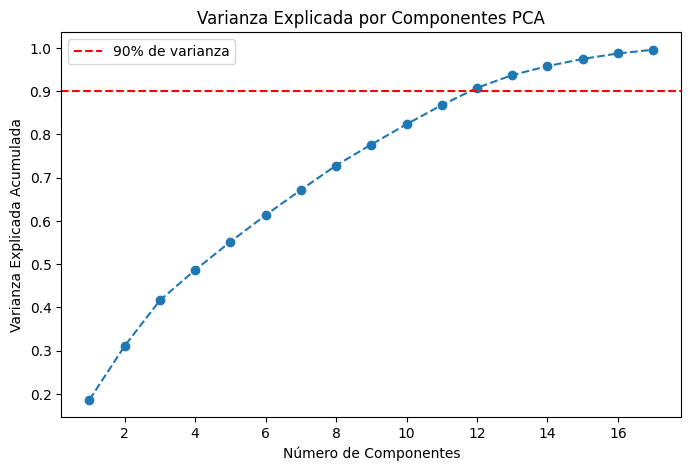

In [117]:

varianza_explicada = np.cumsum(modelo_pca.explained_variance_ratio_)

# Gráfico para ver cuántos componentes capturan al menos el 90% de la varianza
plt.figure(figsize=(8,5))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% de varianza")
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes PCA')
plt.legend()
plt.show()

----------------------

Guardamos el **modelo no supervisado**

In [118]:
import pickle

In [119]:
with open("../modelos/PCA.pkl", "wb") as archiv_model_pca:
    pickle.dump(modelo_pca, archiv_model_pca)

-------------------

### **MODELOS SUPERVISADOS**

R2 score 0.9733979586813167
R2 score train 0.9960525219999851
MAE 32.865941176470585
MSE 1828.7266276470584
RMSE 42.76361336050847
Age                                0.023211
Weight (kg)                        0.004341
Height (m)                         0.004947
Max_BPM                            0.002150
Avg_BPM                            0.105895
Resting_BPM                        0.002447
Session_Duration (hours)           0.827716
Fat_Percentage                     0.011944
Water_Intake (liters)              0.003628
BMI                                0.003588
Male                               0.006590
Workout_Type_Cardio                0.000514
Workout_Type_HIIT                  0.000299
Workout_Type_Strength              0.000544
Workout_Type_Yoga                  0.000501
Workout_Frequency (days/week)_2    0.000244
Workout_Frequency (days/week)_3    0.000368
Workout_Frequency (days/week)_4    0.000335
Workout_Frequency (days/week)_5    0.000265
Experience_Level_1               

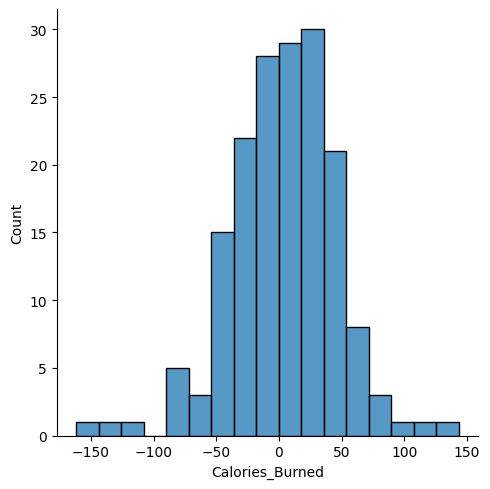

In [151]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar el modelo
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = model_rf.predict(X_test)
print("R2 score", model_rf.score(X_test, y_test))
print("R2 score train",model_rf.score(X_train, y_train))
print("MAE", mean_absolute_error(y_test, y_pred_rf))
print("MSE", mean_squared_error(y_test, y_pred_rf))
print("RMSE", mean_squared_error(y_test, y_pred_rf) ** (1/2))
sns.displot(y_pred_rf - y_test)
feature_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
print(feature_importances)

Sabiendo las columnas que no queremos coger ya que es probable que le usuario no conozca esos datos(como las pulsaciones en la sesión de ejercicio) podemos descartar también las columnas de nivel y frecuencia ya que también estaban altamente correlacionadas con la duración de la sesión

Vamos a coger 11 variables que pueden ser interesantes para el modelo predictivo

In [120]:
X1= df2[['Age', 'Weight (kg)', 'Height (m)','Session_Duration (hours)','Fat_Percentage','Workout_Type_Cardio',
       'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga',"Male","BMI"]]
y1= df2["Calories_Burned"]

In [121]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [122]:
print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(678, 11)
(170, 11)
(678,)
(170,)


In [123]:
scaler = StandardScaler()

X1_train_scal = scaler.fit_transform(X1_train)
X1_test_scal = scaler.transform(X1_test)

Entrenamos con varios modelo supervisados para ver cual nos da mejor resultado

como es de Regresión lineal y queremos ver los mismos datos en todos los modelos creamos una función

In [124]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R2 score", model.score(X_test, y_test))
    print("R2 score train", model.score(X_train, y_train))
    print("MAE", mean_absolute_error(y_test, y_pred))
    print("MSE", mean_squared_error(y_test, y_pred))
    print("RMSE", mean_squared_error(y_test, y_pred) ** (1/2))
    sns.displot(y_pred - y_test)
    return model

R2 score 0.9768322580566334
R2 score train 0.9796939135434669
MAE 31.50001355115659
MSE 1592.6396807952653
RMSE 39.907889956689836


LinearRegression()

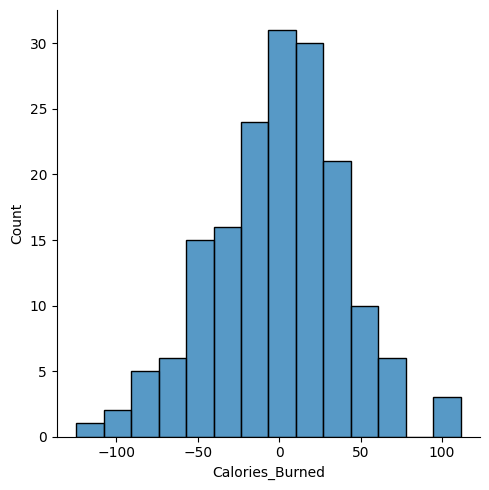

In [125]:
model_1 = train_evaluate_model(LinearRegression(), X_train_pca, y1_train, X_test_pca, y1_test)
model_1

In [126]:
with open("../modelos/pca_reg_ejer.pkl", "wb") as model_pca_reg_ejer:
    pickle.dump(model_1, model_pca_reg_ejer)

Usando X de PCA es muy posible que tengamos overfitting entinces aunque los datos sean mejores en este modelo vamos a usar un X_train

R2 score 0.8884542119129266
R2 score train 0.8679746604862103
MAE 71.4394711155397
MSE 7668.086461223662
RMSE 87.56761080001932


LinearRegression()

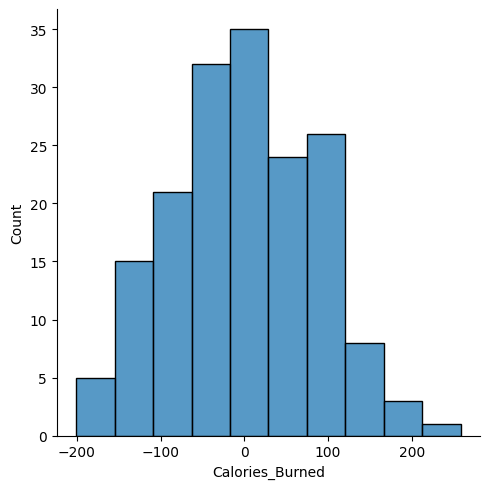

In [127]:
model_2 = train_evaluate_model(LinearRegression(), X1_train_scal, y1_train, X1_test_scal, y1_test)
model_2

R2 score 0.8884542119129265
R2 score train 0.8679746604862103
MAE 71.4394711155397
MSE 7668.086461223667
RMSE 87.56761080001937


LinearRegression()

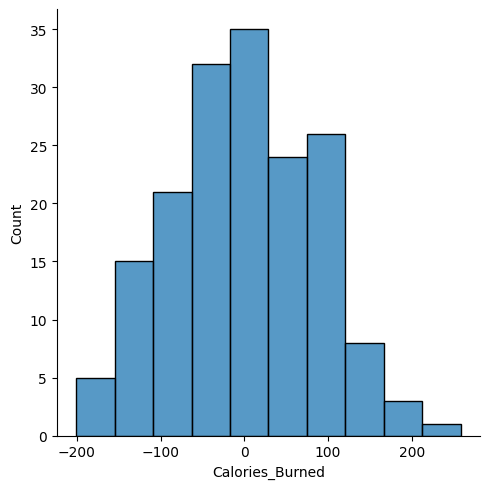

In [128]:
model_3 = train_evaluate_model(LinearRegression(), X1_train, y1_train, X1_test, y1_test)
model_3

Con modelos de regresión lineal no varía si usamos datos escalados o sin escalar

R2 score 0.8858683150719311
R2 score train 0.8667408437623745
MAE 73.17229914803684
MSE 7845.850955039238
RMSE 88.57680822336758


Ridge(alpha=2)

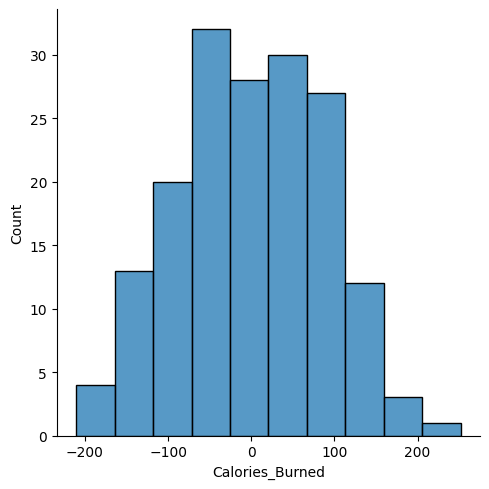

In [129]:
model_4 = train_evaluate_model(Ridge(alpha=2), X1_train, y1_train, X1_test, y1_test)
model_4

Obtenemos unos valores muy similares a los modelos anteriores, pero ligeramente peores

R2 score 0.8932501239821996
R2 score train 0.8825634354384349
MAE 68.94984126559174
MSE 7338.3970212341865
RMSE 85.66444432338417


LinearRegression()

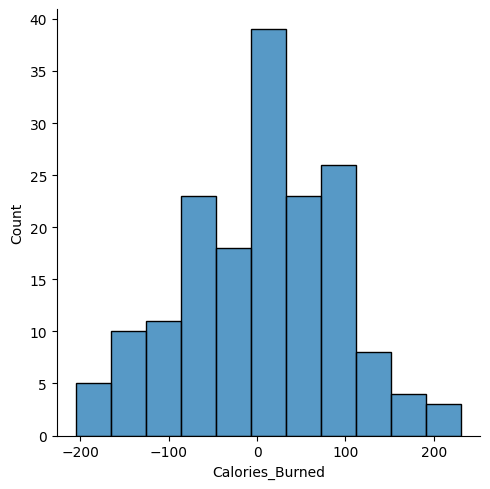

In [130]:
pol_2= PolynomialFeatures(degree=2)

X_train_pol2 = pol_2.fit_transform(X1_train)
X_test_pol2 = pol_2.transform(X1_test)

model_5 = train_evaluate_model(LinearRegression(), X_train_pol2, y1_train, X_test_pol2, y1_test)
model_5

In [131]:
# Guardar el transformador PolynomialFeatures
with open("../modelos/pol2_transform_ejer.pkl", "wb") as pol_transf_ejer:
    pickle.dump(pol_2, pol_transf_ejer)

In [132]:
with open("../modelos/pol2_ejer.pkl", "wb") as model_pol2_ejer:
    pickle.dump(model_5, model_pol2_ejer)

R2 score 0.8648127440459994
R2 score train 0.9197284739778846
MAE 79.00778240629157
MSE 9293.291883882259
RMSE 96.40172137406188


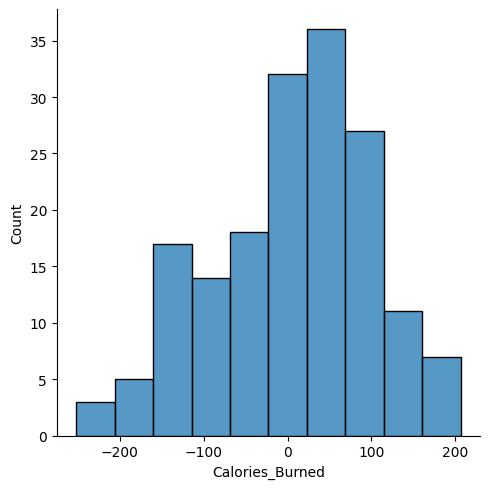

In [133]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rnd_reg = RandomForestRegressor(n_estimators=200,
                                 max_leaf_nodes=32,
                                 random_state=42)
rnd_reg.fit(X1_train, y1_train)

y_pred_reg = rnd_reg.predict(X1_test)
print("R2 score", rnd_reg.score(X1_test, y1_test))
print("R2 score train",rnd_reg.score(X1_train, y1_train))
print("MAE", mean_absolute_error(y1_test, y_pred_reg))
print("MSE", mean_squared_error(y1_test, y_pred_reg))
print("RMSE", mean_squared_error(y1_test, y_pred_reg) ** (1/2))
sns.displot(y_pred_reg - y1_test)

In [134]:
with open("../modelos/rnd_ejer.pkl", "wb") as model_rnd_ejer:
    pickle.dump(rnd_reg, model_rnd_ejer)

Valorando todos los modelos tenemos que los mejor son el polinímico de grado dos y el RandomForest.

En el primero tenemenos una bajada de la cantidad de datos en la dispersión, se centran entorno a 0 auqnue tenemos algunas irregularidades. El R2 score es muy alto en train y ha bajado en test ligeramente,mientras que en el random forest sube un poco en test. Respecto a la metrica qeu estamos usando para guiarnos vemos que el Mae es mucho mejor en el modelo polinomico

-------------------------

Evaluamos con el datset de test

In [ ]:
df_kcal=pd.read_csv("../data/df_test_kcal.csv")

In [ ]:
X_kcl= df_kcal[['Age', 'Weight (kg)', 'Height (m)','Session_Duration (hours)','Fat_Percentage','Workout_Type_Cardio',
       'Workout_Type_HIIT', 'Workout_Type_Strength', 'Workout_Type_Yoga',"Male","BMI"]]


C:\Users\UX490U\AppData\Local\Temp\ipykernel_7512\2296361264.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_kcal=df_kcal.replace({True:1,False:0})


Hacemos predicciones con el modelos de pol_2 y con el rnd

In [140]:
X_kcl_pol2 = pol_2.transform(X_kcl)
y_pred_kcal_pol2 = model_5.predict(X_kcl_pol2)

In [141]:
y_pred_kcal_pol2=np.round(y_pred_kcal_pol2)

In [142]:
prediccion_pol2=pd.DataFrame({"kcal":y_pred_kcal_pol2,"Kcal_real":df_kcal["Calories_Burned"]})

In [169]:
prediccion_pol2[8:15]

,kcal,Kcal_real
8,441.0,454.0
9,1148.0,1107.0
10,699.0,576.0
11,507.0,433.0
12,1015.0,911.0
13,994.0,864.0
14,693.0,621.0


In [168]:
y_pred_kcal_rnd = np.round(rnd_reg.predict(X_kcl))
prediccion_rnd=pd.DataFrame({"kcal":y_pred_kcal_rnd,"Kcal_real":df_kcal["Calories_Burned"]})
prediccion_rnd[8:15]

,kcal,Kcal_real
8,496.0,454.0
9,1118.0,1107.0
10,737.0,576.0
11,507.0,433.0
12,997.0,911.0
13,1010.0,864.0
14,733.0,621.0


**Evaluamos que modelo de los escogidos nos da mejores resultados en test**

In [145]:
df_comprobar_pol2=pd.DataFrame({"y_pred":prediccion_pol2["kcal"],"y_real": df_kcal["Calories_Burned"]})

In [146]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_comprobar_pol2["y_real"], df_comprobar_pol2["y_pred"])
mse = mean_squared_error(df_comprobar_pol2["y_real"], df_comprobar_pol2["y_pred"])
rmse = np.sqrt(mse)
r2 = r2_score(df_comprobar_pol2["y_real"],df_comprobar_pol2["y_pred"])

# Mostrar resultados
print(f"MAE: {mae:.2f} kcal")
print(f"RMSE: {rmse:.2f} kcal")
print(f"R² Score: {r2:.2f}")#(Cuanto más cerca de 1, mejor)

MAE: 85.37 kcal
RMSE: 107.15 kcal
R² Score: 0.86


In [147]:
df_comprobar_rnd=pd.DataFrame({"y_pred":prediccion_rnd["kcal"],"y_real": df_kcal["Calories_Burned"]})

In [148]:
mae = mean_absolute_error(df_comprobar_rnd["y_real"], df_comprobar_rnd["y_pred"])
mse = mean_squared_error(df_comprobar_rnd["y_real"], df_comprobar_rnd["y_pred"])
rmse = np.sqrt(mse)
r2 = r2_score(df_comprobar_rnd["y_real"],df_comprobar_rnd["y_pred"])

# Mostrar resultados
print(f"MAE: {mae:.2f} kcal")
print(f"RMSE: {rmse:.2f} kcal")
print(f"R² Score: {r2:.2f}")#(Cuanto más cerca de 1, mejor)

MAE: 88.28 kcal
RMSE: 109.79 kcal
R² Score: 0.85


El modelo polinomico nos da resultados ligeramnete peores, por lo que nos quedaremos con el random_forest para hacer las predicciones

--------------------------

-----------------------------